## Experimentation Notebook  ##

This notebook contains codes for various experimation tried for any thing.

### Generate dataset for the training ###

* Improve performance to fetch data for training model in GPU, so that GPU does not wait much while data is prepared.
* Experiment with various technique with tf.Data.Dataset to check avg time it take to prepare data with a given batch size.

text input to model is a sequence. e.g "green dress with white top" will generate data points as 
<table>
<tr><td>index</td><td>X</td><td>Y</td></tr>
<tr><td>0</td><td>[start]</td><td>[green]</td></tr>
<tr><td>1</td><td>[green]</td><td>[dress]</td></tr>
<tr><td>2</td><td>[green dress]</td><td>[with]</td><tr>
<tr><td>3</td><td>[green dress with]</td><td>[white]</td><tr>
<tr><td>4</td><td>[green dress with white]</td><td>[top]</td><tr>
</table>

#### Trial 1 ####

In [ ]:
from keras.utils import pad_sequences
from keras.utils import to_categorical
import numpy as np
import h5py
import os

def data_generator(dbset, token_obj, max_length, vocab_size, name):
  
    HDF5_FILEPATH = os.path.join(PROJECT_ROOT, 'data', 'processed', name)
    x_name = 'np_image'
    y_name = 'id_image'

    with h5py.File(HDF5_FILEPATH, 'r') as hdf5_file:

        record_cnt = hdf5_file[y_name].shape[0]
        map_image_id_index = dict(zip(hdf5_file[y_name][:].flatten(), range(record_cnt)))

        #for index in range(dbset.shape[0]): #Error, as loc retrive records based on the index value. If index value not present it will raise error
        for index in dbset.index:
            
            image_id = int(dbset.loc[index,'id'])
            caption = str(dbset.loc[index,'preprocess_caption'])

            image_id_index = int(map_image_id_index[image_id])
            np_image = hdf5_file[x_name][image_id_index]

            #input_sequence, output_word = create_sequences_dataset(dbset.loc[index,:], token_obj, max_length, vocab_size)
            np_image, input_sequence, output_word = create_sequences_dataset(caption, token_obj, max_length, vocab_size, np_image)           

            yield [[np_image, input_sequence], output_word]

            del [np_image, input_sequence, output_word]    

#def create_sequences_dataset(dbset, token_obj, max_length, vocab_size):
def create_sequences_dataset(desc, token_obj, max_length, vocab_size, np_image):

    #image_id, X, y = np.array(), np.array(), np.array()
    image_ids , X, y = None, None, None
    
    #text_token_seq = token_obj.texts_to_sequences(list(dbset['preprocess_caption'])) #Output seq of each caption text in the dataset 
    text_token_seq = token_obj.texts_to_sequences([desc])
    #np_image = np.expand_dims(np_image, axis = 0)

    for seq in text_token_seq:
      
        # split one sequence into multiple X,y pairs
        image_seq, in_seq, out_seq = list(), list(), list() 

        for i in range(1, len(seq)):

            # split into input and output pair
            in_seq.append(seq[:i])
            out_seq.append(seq[i]) 
            image_seq.append(np_image)
            
        # pad input sequence
        in_seq = pad_sequences(in_seq, maxlen = max_length)
        
        # encode output sequence
        out_seq = to_categorical(out_seq, num_classes = vocab_size)
        
        # store
        if type(X) == type(None):

            #image_id = np.array([dbset.iloc[index, 0]] * len(in_seq)) #Column location of 'id': 0
            image_ids = np.array(image_seq)
            X = np.array(in_seq)
            y = np.array(out_seq)
            
          
        else:

            #image_id = np.append(image_id, np.array([dbset.iloc[index, 0]] * len(in_seq)), axis = 0) #Column location of 'id': 0
            image_ids = np.append(image_ids, np.array(image_seq), axis = 0)
            X = np.append(X, np.array(in_seq), axis = 0)
            y = np.append(y, np.array(out_seq), axis = 0)

        del [image_seq, in_seq, out_seq]

    return image_ids, X, y
    #return np.array(image_id), np.array(X), np.array(y)

#Sample code to check
#[a,b],c = next(data_generator(db_train, token_obj, max_length, vocab_size, 'train_data.h5'))
#a.shape, b.shape, c.shape 
#>>>((7, 1024, 1024, 3), (7, 15), (7, 10613))

**Comment**: 
* Above generator technique where we create in_seq and out_seq during training time, takes lot of time, 
* Since most of the time was spend by CPU to generate the in_seq and out_seq for each datapoint. 
* So tried alternative approach to precompute in_seq, out_seq, image_idx. Then saved this precomputed to a file.
* So at time of training it only has to read the hdf5 to get numpy represention of image using the hdf5 index for each image.
* Average time to read numpy image represenation from hdf5 was 1.2 sec(Including opening the file and read the image by there index position).

According to tensorflow doc: tf with generator, While this is a convenient approach it has limited portability and scalability. It must run in the same python process that created the generator, and is still subject to the Python GIL

#### Trial 2 ####

In this try we will discuss problem faced when generating precomputed in_seq, out_seq and image_id files based on the understanding from trail 1 comment.

* Problem faced was the even if the pre-computed file was of size 3.5MB. Faced multiple "memory" error when try to save and load the file. In case of GPU system in kaggel notebook it always gave error. When generated in_out_seq file on laptop it ran sucessfully without memory issue(had to close all the application and keep RAM empty by removing unwanted process). The memory issue was because of out_seq contain list type with size of each list is 10613.

##### Save in_out seq data #####
Things tried to save in_out seq file of training data.
 

In [ ]:
#Try-1: Failed most of the time. But was sucessfully only once and that's how i created the file on my machine.

#Faced error "ArrowMemoryError: realloc of size 8468299776 failed". 
train_data.to_parquet(os.path.join(PROJECT_ROOT, 'data', 'processed', 'train_in_seq_data.parquet'), engine = 'pyarrow', compression = 'gzip')


In [ ]:
#Try-2: Failed to save in json format. Save error memory error.

train_data.to_json(os.path.join(PROJECT_ROOT, 'data', 'processed', 'train_in_seq_data.parquet')) 


In [ ]:
#Try-3: Did not tried this code. But noted this just for future reference. 
# Saving the file in batchs, each batch we updating existing file by appending the new batch in them.
# Reference: https://towardsdatascience.com/4-ways-to-write-data-to-parquet-with-python-a-comparison-3c4f54ee5fec

import fastparquet as fp

# SETTING BATCH SIZE
batch_size = 128

# SEQUENTIALLY APPEND TO PARQUET FILE
file_name: os.path.join(PROJECT_ROOT, 'data', 'processed', 'train_in_seq_data.parquet')
start_idx = 0

for end_idx in range(128, range(train_data.shape[0])):

    # Write the rows to the Parquet file
    fp.write(file_name, train_data[start_idx: end_idx], append = True, compression = 'GZIP')

    start_idx = end_idx

print(f'Full parquet file named "%s" has been written to disk with %s total rows', os.path.join('data', 'processed', 'train_in_seq_data.parquet'), train_data.shape[0])

del [train_data]
gc.collect()


In [ ]:
#Try-4: Tried saving the file in chunk using the property in the to_parquet. It uses "row_group_offsets" propery when saving to parquet file and require to engine='fastparquet' at time of saving. 

#Refer: https://www.practicaldatascience.org/html/parquet.html#:~:text=Parquet%20allows%20chunking%2C%20but%20not,you%20can%20chunk%20a%20csv

# Also gave error "The truth value of an array with more than one element is ambiguous. Use a.any() or a.all() parquat"
#This error could be due to fact that we are using list of list.

#Since file got created once sucessfully using the code at mention in "Try-1" did not search more on this.

##### Load in_out seq data #####

Similary to memory issue faced when saving, faced memory issue when loading the file. Mainly in kaggel GPU system which had 13 GB RAM available. 
Did not face any issue when working with CPU with 30 GB RAM.

* Advantage of reading the parquat file in chunk is, do not need to load then then entire dataset in memory. We shall load as in demand. 
* Since we use "pyarrow" engine when saving the file, it has a option to read the records in batch.


In [ ]:
#Saving with pyarrow engine, can use read a file using pq.ParquetFile and iterate over with a batch size
#https://arrow.apache.org/docs/python/generated/pyarrow.parquet.ParquetFile.html#pyarrow.parquet.ParquetFile.iter_batches

# Sample code
%%time

import pyarrow.parquet as pq

DATASET_FILEPATH = os.path.join(PROJECT_ROOT, 'train_in_seq_data.parquet')
parquet_obj = pq.ParquetFile(DATASET_FILEPATH)
cnt = 0
for dbset in parquet_obj.iter_batches(batch_size = 100):
    dbset = dbset.to_pandas()
    cnt += dbset.shape[0]
    print(dbset.head())
print(cnt)

#Will use this approach for data_generation for training the model.

#### Trial 3 ####

Case when entire train in_out seq file can be loaded in the memory. In that case we can generate "map" in tf.data.Dataset to get data for trail. 

* Using "map" to generate dataset. Tried this approch since with map we can parallelize the task
* Refer: https://medium.com/@acordier/tf-data-dataset-generators-with-parallelization-the-easy-way-b5c5f7d2a18

In [ ]:
import h5py

def your_processing_function(i, name):
    

    if 'valid' in name:
        dbset = valid_data
    else:
        dbset = train_data
       

    HDF5_FILEPATH = os.path.join(PROJECT_ROOT, 'data', 'processed', name)
    x_name = 'np_image'
    
    with h5py.File(HDF5_FILEPATH, 'r') as hdf5_file: 
        
        image_id_idx = dbset.loc[i, 'image_id_idx']
        image_np = hdf5_file[x_name][image_id_idx]
        
        in_seq = dbset.loc[i, 'in_seq']
        
        out_seq = dbset.loc[i, 'out_seq']
        
        return image_np, in_seq , out_seq

def func(i, name):
    
    i = i.numpy() # Decoding from the EagerTensor object
    name = str(name.numpy(), 'UTF-8')
        
    img, in_seq, out_seq = your_processing_function(i, name)
    return img, in_seq, out_seq

z = list(range(len(train_data))) # The index generator

dataset = tf.data.Dataset.from_generator(lambda: z, tf.uint32)
#With tf.py_function we can write out python code i.e if,else etc. Input arg are passed as tensor
dataset = dataset.map(lambda i: tf.py_function(func=func, 
                                               inp = [i, 'train_data.h5'], 
                                               Tout= [tf.float16, tf.int32, tf.float16]
                                               ), 
                      num_parallel_calls = tf.data.AUTOTUNE)
dataset = dataset.batch(128)

#for x,y,z in dataset:
#    print(x.shape)
#    print(y.shape)
#    print(y)
#    print(z.shape)
#    break

**Comment:**
* Using "map" with tf.data.Dataset it still took 1min 58s to generate batch 128 records 

#### Trial 4 #### 

Reading the train in_out seq file in chunk create a new data_generate that can be used for training the model in GPU system.
 
Advantage: do not need to load the entire train/valid data in memory, will load as an when need.

In [ ]:
#Sample code, how train data was loaded
#With limited RAM in GPU System. Loading the train data fails. So went to alternative approach to read the data in chunk
#train_data = pd.read_parquet(os.path.join(PROJECT_ROOT, 'data', 'processed', 'train_in_seq_data.parquet'),
#                            columns = ['image_id_idx', 'in_seq', 'out_seq'],
#                            engine = 'pyarrow',
#)

import pyarrow.parquet as pq
import h5py

def next_dbset_batch(parquet_obj, size = 10000):
    
    for dbset in parquet_obj.iter_batches(batch_size = size):
        yield dbset

def data_generator(name, batch_size): 
    
    #print(name) output: b'train_data.h5'. Here 'b' in output mease byte representation
    name = str(name, 'UTF-8') #This  convert bytes to a string
    #batch_size = batch_size.numpy()

    if 'valid' in name:

        #dbset = valid_data
        DATASET_FILEPATH = 'valid_in_seq_data.parquet'
        HDF5_FILEPATH = 'validate_data.h5'
        
    else:

        #dbset = train_data
        DATASET_FILEPATH = 'train_in_seq_data.parquet'
        HDF5_FILEPATH = 'train_data.h5'

    DATASET_FILEPATH = os.path.join(PROJECT_ROOT, DATASET_FILEPATH) 
    parquet_obj = pq.ParquetFile(DATASET_FILEPATH)

    HDF5_FILEPATH = os.path.join(PROJECT_ROOT, 'data', 'processed', HDF5_FILEPATH)
    x_name = 'np_image'

    with h5py.File(HDF5_FILEPATH, 'r') as hdf5_file:        
        
        #records_cnt = hdf5_file[x_name].shape[0]
        for dbset in next_dbset_batch(parquet_obj, batch_size): #read the data in chunk

            dbset = dbset.to_pandas()
            records_cnt = dbset.shape[0]
            
            for idx in range(records_cnt):

                image_id_idx = dbset.loc[idx, 'image_id_idx']
                in_image = hdf5_file[x_name][image_id_idx] 
                in_seq = dbset.loc[idx, 'in_seq']

                out_seq = dbset.loc[idx, 'out_seq']
                yield ((np.array(in_image), np.array(in_seq.tolist())), np.array(out_seq.tolist())) 


from tensorflow.data import Dataset

train_batch = (Dataset
              .from_generator(data_generator, 
                              args = ['train', 25000], #batch_size
                              output_signature = (
                                                    (
                                                      tf.TensorSpec(shape = (1024, 1024, 3), dtype = tf.float16), 
                                                      tf.TensorSpec(shape = (max_in_seq_len,), dtype = tf.int32)
                                                    ),
                                                    tf.TensorSpec(shape = (vocab_size,), dtype = tf.float16)
                                                  )
                            )              
              .prefetch(batch_size*2) 
              .batch(batch_size)                             
              )


**Comment:**
1. This approach did not help in the time taken to fetch the data.


Did futher analysis to better understand where most of the time is spent.

In [ ]:
import pyarrow.parquet as pq
import h5py
import os
import time

def data_generator(name, batch_size): 
    
    name = str(name, 'UTF-8')
    
    if 'valid' in name:
        
        #dbset = valid_data
        DATASET_FILEPATH = 'valid_in_seq_data.parquet'    
        HDF5_FILEPATH = os.path.join('validate_data', 'validate_data.h5')
        
    else:
        
        #dbset = train_data
        DATASET_FILEPATH = 'train_in_seq_data.parquet'
        HDF5_FILEPATH = os.path.join('train_data', 'train_data.h5')

    DATASET_FILEPATH = os.path.join(PROJECT_ROOT, DATASET_FILEPATH)
    parquet_obj = pq.ParquetFile(DATASET_FILEPATH)    
    
    HDF5_FILEPATH = os.path.join(PROJECT_ROOT, HDF5_FILEPATH)
    x_name = 'np_image'
    
    #with h5py.File(HDF5_FILEPATH, 'r') as hdf5_file: $uncomment this like to check the time taken when read image numpy instead of image_id 
    for dbset in next_dbset_batch(parquet_obj, batch_size): #read the data in chunk

        dbset = dbset.to_pandas()
        records_cnt = dbset.shape[0]
        
        for idx in range(records_cnt):
            
            image_id_idx = dbset.loc[idx, 'image_id_idx']
            #in_image = hdf5_file[x_name][image_id_idx] 
                                
            in_seq = dbset.loc[idx, 'in_seq']

            out_seq = dbset.loc[idx, 'out_seq']
            
            yield image_id_idx, in_seq.tolist(), out_seq.tolist() 
            #yield in_image, in_seq.tolist(), out_seq.tolist() #Uncomment to return numpy image instead of image_idx

        del [dbset]
        gc.collect()
    
    parquet_obj.close()





from tensorflow.data import Dataset
import tensorflow as tf 

batch_size = 90
max_in_seq_len = 15
vocab_size = 10613

train_batch = (Dataset
              .from_generator(data_generator, 
                              args = ['train', 25000], #batch_size
                              output_signature = (
                                                      tf.TensorSpec(shape = (), dtype = tf.int32)
                                                      #tf.TensorSpec(shape = (1024,1024,3), dtype = tf.float16), #Uncomment when numpy image is retrun instead of image_idx
                                                      tf.TensorSpec(shape = (max_in_seq_len,), dtype = tf.int32),                                                    
                                                      tf.TensorSpec(shape = (vocab_size,), dtype = tf.float16)
                                                  )
                            )              
              .prefetch(batch_size*2) 
              .batch(batch_size)              
              )

In [ ]:
%%time

import time
start = time.time()
idx = 0
for x,y,z in train_batch:
    
    end = time.time()
    print(f'Batch: {idx}, elapse time: {(end - start)}')
    
    #print(x.shape)    
    #print(y.shape) 
    #print(z.shape) 
    idx +=1
    start = time.time()
    if idx == 3:    
        break

**Comment:**
* It took 5sec to generate 270 records in batch. 

So most of the time is spend to read numpy array from hdf5 file. When tried the above code after modification to read the numpy image array it took 5m aprox to read 270 records.

So now tried various approach to speed up the read time from hdf5.

In [ ]:
# Define hdf5 file object as a global varaible 

hdf5_file = h5py.File('/kaggle/input/fashion-image-encoding/train_data/train_data.h5', 'r') #Define hdf5 object at global level
PROJECT_ROOT = '/kaggle/input/fashion-image-encoding'
def next_dbset_batch(parquet_obj, size = 10000):
    
    for dbset in parquet_obj.iter_batches(batch_size = size, columns = ['image_id_idx', 'in_seq', 'out_seq']):
        yield dbset


def data_generator(name, batch_size): 
    
    name = str(name, 'UTF-8')
    
    if 'valid' in name:
        
        #dbset = valid_data
        DATASET_FILEPATH = 'valid_in_seq_data.parquet'    
        HDF5_FILEPATH = os.path.join('validate_data', 'validate_data.h5')
        
    else:
        
        #dbset = train_data
        DATASET_FILEPATH = 'train_in_seq_data.parquet'
        HDF5_FILEPATH = os.path.join('train_data', 'train_data.h5')

    DATASET_FILEPATH = os.path.join(PROJECT_ROOT, DATASET_FILEPATH)
    parquet_obj = pq.ParquetFile(DATASET_FILEPATH)
    
    HDF5_FILEPATH = os.path.join(PROJECT_ROOT, HDF5_FILEPATH)
    x_name = 'np_image'  
        

    #records_cnt = hdf5_file[x_name].shape[0]
    for dbset in next_dbset_batch(parquet_obj, batch_size): #read the data in chunk

        dbset = dbset.to_pandas()
        records_cnt = dbset.shape[0]
        
        #since we know that the records will be in sequence. 
        
        for idx in range(records_cnt):

            image_id_idx = dbset.loc[idx, 'image_id_idx']
            in_image = hdf5_file[x_name][image_id_idx] 
            
            in_seq = dbset.loc[idx, 'in_seq']

            out_seq = dbset.loc[idx, 'out_seq']
            yield in_image, in_seq.tolist(), out_seq.tolist()
        

        del [dbset]
        gc.collect()
    
    parquet_obj.close()

**Comment:**

* When define hdf5 file object global varaible, time taken for 270 records reduce to 4min. It took 0.85 sec approx to read the a single value from HDF5.

Let's try if we use "map" with parallization if we can improve this time.
1. When hdf5 is define global
2. When hdf5 is not define global
In both the above case we will use "map" to parallization to note the time.


In [ ]:
# When hdf5 is define global/not global


import pyarrow.parquet as pq
import h5py
import os
import time

#hdf5_file = h5py.File('/kaggle/input/fashion-image-encoding/train_data/train_data.h5', 'r') #Define hdf5 object at global level.Modify the code when want to try with global hdf5 object

PROJECT_ROOT = '/kaggle/input/fashion-image-encoding'
def next_dbset_batch(parquet_obj, size = 10000):
    
    for dbset in parquet_obj.iter_batches(batch_size = size, columns = ['image_id_idx', 'in_seq', 'out_seq']):
        yield dbset

def map_generator(name, image_id_idx, in_seq, out_seq):#*inp
    
    #image_id_idx = inp[0][0]
    #in_seq = inp[0][1]
    #out_seq = inp[1]
    
    #print(image_id_idx.numpy())
    #print(image_id_idx)
    #print(in_seq)
    #print(out_seq)
        
    name = str(name.numpy(), 'UTF-8')
    #print(name)
    
    if 'valid' in name:
        
        #dbset = valid_data
        #DATASET_FILEPATH = 'valid_in_seq_data.parquet'    
        HDF5_FILEPATH = os.path.join('validate_data', 'validate_data.h5')
        
    else:
        
        #dbset = train_data
        #DATASET_FILEPATH = 'train_in_seq_data.parquet'
        HDF5_FILEPATH = os.path.join('train_data', 'train_data.h5')
    
    HDF5_FILEPATH = os.path.join(PROJECT_ROOT, HDF5_FILEPATH)
    x_name = 'np_image'
    
    start = time.time()
    with h5py.File(HDF5_FILEPATH, 'r') as hdf5_file: #Comment this line when want to use global hdf5 object
        
        #print("opened hdf5")
        in_image = hdf5_file[x_name][image_id_idx.numpy()] 
            #print("access opened hdf5")
            #print(in_image.shape)
        end = time.time()
        print(f'Elapse time to get the records: {(end - start)}')

        return in_image , in_seq, out_seq
    
    #return tf.convert_to_tensor(in_image) , in_seq, out_seq
        #return (in_image, in_seq), out_seq

def data_generator(name, batch_size): 
    
    name = str(name, 'UTF-8')
    
    if 'valid' in name:
        
        #dbset = valid_data
        DATASET_FILEPATH = 'valid_in_seq_data.parquet'    
        
    else:
        
        #dbset = train_data
        DATASET_FILEPATH = 'train_in_seq_data.parquet'

    DATASET_FILEPATH = os.path.join(PROJECT_ROOT, DATASET_FILEPATH)
    parquet_obj = pq.ParquetFile(DATASET_FILEPATH)
    
    #records_cnt = hdf5_file[x_name].shape[0]
    for dbset in next_dbset_batch(parquet_obj, batch_size): #read the data in chunk

        dbset = dbset.to_pandas()
        records_cnt = dbset.shape[0]
                    
        for idx in range(records_cnt):

            image_id_idx = dbset.loc[idx, 'image_id_idx']
                
            in_seq = dbset.loc[idx, 'in_seq']

            out_seq = dbset.loc[idx, 'out_seq']
            yield image_id_idx, in_seq.tolist(), out_seq.tolist() #used with map in tf.data
            
        del [dbset]
        gc.collect()
    
    parquet_obj.close()







from tensorflow.data import Dataset
import tensorflow as tf 

batch_size = 90
max_in_seq_len = 15
vocab_size = 10613

train_batch = (Dataset
              .from_generator(data_generator, 
                              args = ['train', 25000], #batch_size
                              output_signature = (
                                                     
                                                      tf.TensorSpec(shape = (), dtype = tf.int32), 
                                                      tf.TensorSpec(shape = (max_in_seq_len,), dtype = tf.int32),
                                                    
                                                      tf.TensorSpec(shape = (vocab_size,), dtype = tf.float16)
                                                  )
                            )              
              .prefetch(batch_size*2) 
              #.map(lambda x,y,z: map_generator('train',x,y,z)) #Code tried to access without tf.py_funnction. # But will not work as image_idx will in in form of tensor. and fail to access the tensor value. Refer later code to understand 
              .map(lambda im,i,o: tf.py_function(func = map_generator, 
                                               inp = ['train',im,i,o],
                                                 Tout= [
                                                       
                                                      tf.TensorSpec(shape = (1024,1024,3), dtype = tf.float16), 
                                                      tf.TensorSpec(shape = (max_in_seq_len,), dtype = tf.int32),
                                                       
                                                      tf.TensorSpec(shape = (vocab_size,), dtype = tf.float16)
                                               ]                                               
                                               ) 
                    ,num_parallel_calls = tf.data.AUTOTUNE
                  )
              .batch(batch_size)
              
              )

In [ ]:
%%time

import time
start = time.time()
idx = 0
for x,y,z in train_batch:
    
    end = time.time()
    print(f'Batch: {idx}, elapse time: {(end - start)}')
    
    #print(x.shape)    
    #print(y.shape) 
    #print(z.shape) 
    idx +=1
    start = time.time()
    if idx == 3:    
        break

**Comment:**
* Define hdf5 file object with global varaible with 270 records and running map in parallel did not help at all. It took 4min only. No improvement. One think observed that time take to read an individual records from hdf5 increased. Now it take 3.4sec approx to read a single value from hdf5. May be this is the reason it did not perform well in parallel. Reason for increase in time map be due to GIL problem in Python.
* When define hdf5 file within the generator with map in parallel. No improvement to retrive time still 4m to access 270 records.


##### We can not reduce the read time for hdf5. Only way is to reduce the number of read from the hdf5 #####
As the input data will be in sequence. So when we read a nupy image for a datapoint. We can use the same numpy image array for next few datapoints which are part of the previous datapoint.

When tried this approach it took 39.5sec to read 270 records. Which very fast.


https://www.kaggle.com/code/burhanuddinlatsaheb/image-captioning-vit-gpt2

### Hugging Face ###

In [1]:
from datasets import load_dataset

ds = load_dataset("lambdalabs/pokemon-blip-captions")
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to C:/Users/smithau8/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [3]:
import numpy as np

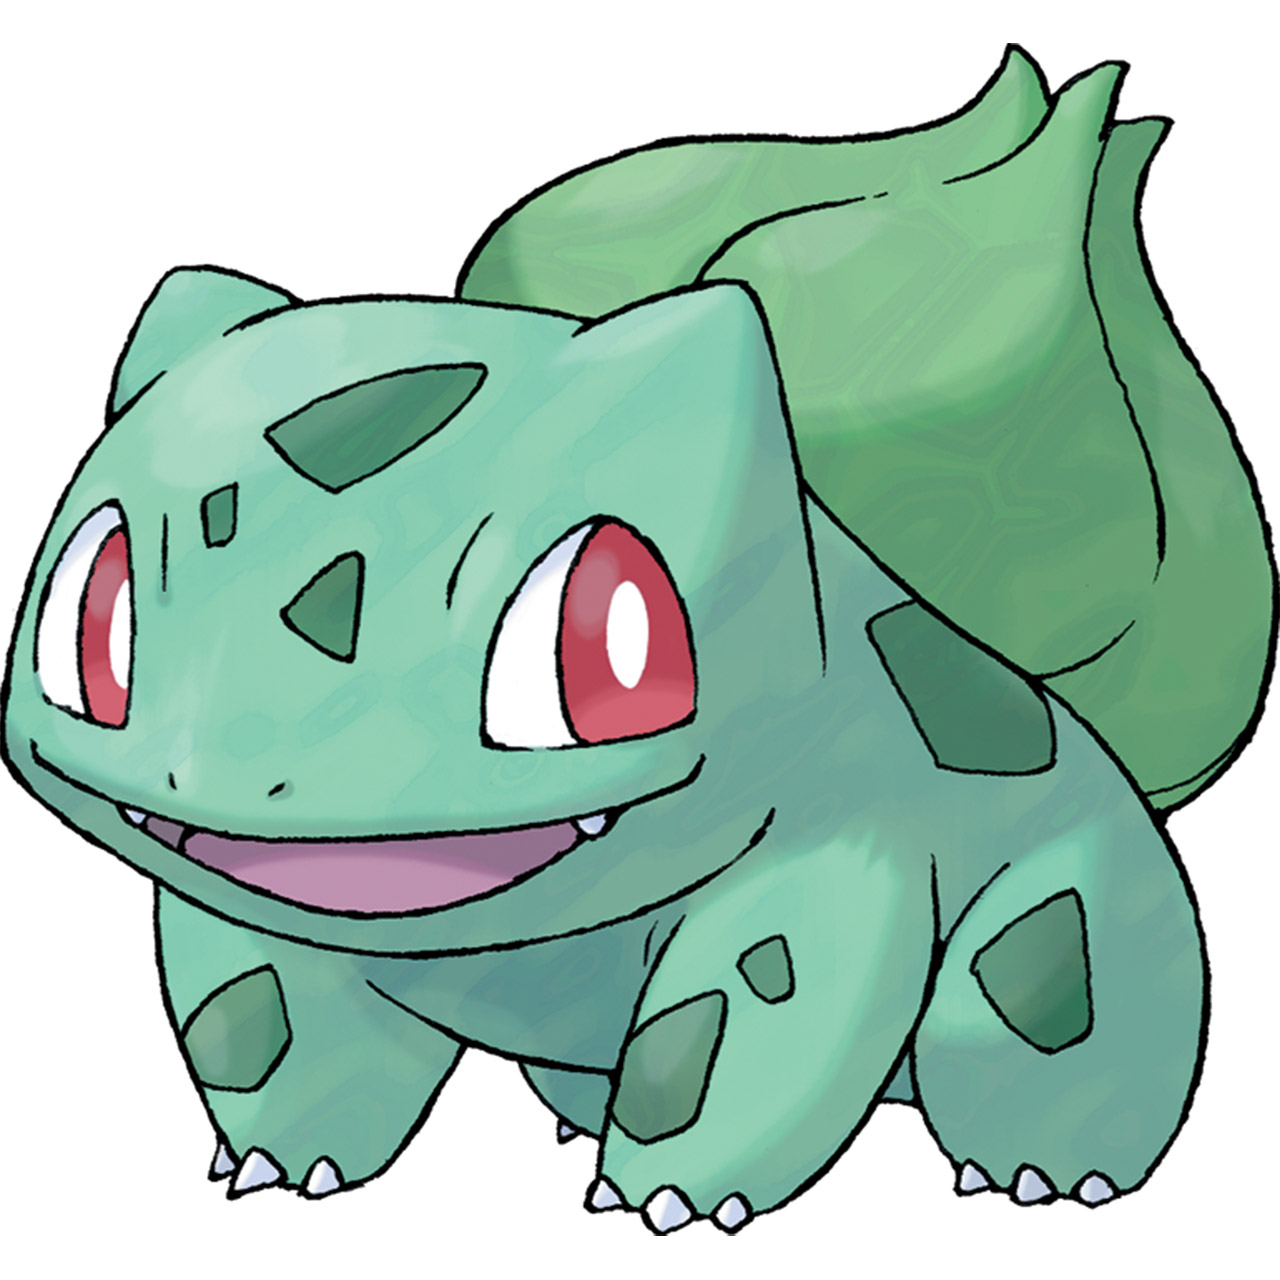

In [5]:
ds['train'][0]["image"]

In [6]:
ds['train'][0]["image"].type

AttributeError: type